## Plotting:

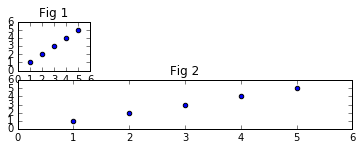

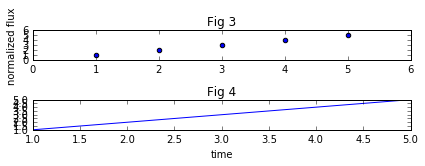

In [37]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
%matplotlib inline
x = [1,2,3,4,5]
y = [1,2,3,4,5]
plt.figure(1)
ax1 = plt.subplot(441)
ax1.set_title('Fig 1')
ax1.scatter(x,y)
ax2 = plt.subplot(412)
ax2.scatter(x,y)
ax2.set_title('Fig 2')
plt.figure(2)
ax3 = plt.subplot(413)
plt.ylabel('normalized flux')
ax3.scatter(x,y)
ax3.set_title('Fig 3')
ax4 = plt.subplot(414)
ax4.plot(x,y)
ax4.set_title('Fig 4')
plt.xlabel('time')
plt.tight_layout()
plt.show()


## Pandas Dataframes:

In [81]:
import numpy as np
import pandas as pd
f1 = [[1,2,3],[2,3,1],[3,1,2]]
f2 = f3 = [1,2,3]
df = pd.DataFrame({'f1':f1,'f2':f2,'f3':f3},index=['alpha','bravo','charlie'])
df

,f1,f2,f3
alpha,"[1, 2, 3]",1,1
bravo,"[2, 3, 1]",2,2
charlie,"[3, 1, 2]",3,3


In [57]:
df[df.index.str.contains('|'.join(['alpha','bravo']))]

,f1,f2,f3
alpha,"[1, 2, 3]",1,1
bravo,"[2, 3, 1]",2,2


In [90]:
a = np.array(df[['f2','f3']])
a[:,0]

array([1, 2, 3])

### Add a feature

In [70]:
df['f4']=list(np.array([[1,2,3],[2,3,1],[3,1,2]]))


In [71]:
df2 = pd.DataFrame({'f1':[[4,4,4]],'f2':[4],'f3':[4],'f4':[[4,4,4]]},index=['delta'])

In [76]:
df = df.drop(df.index[0])
df = df.append(df2)
df

,f1,f2,f3,f4
bravo,"[2, 3, 1]",2,2,"[2, 3, 1]"
charlie,"[3, 1, 2]",3,3,"[3, 1, 2]"
delta,"[4, 4, 4]",4,4,"[4, 4, 4]"


In [26]:
import pandas as pd
import sys
sys.path.append('python')
import keplerml

data = pd.read_csv('data/output/out.csv',index_col=0)
fitsDir = 'data/Training_set_lightcurves/'
files = data.index


Importing lightcurve data from data/Training_set_lightcurves/
Finished importing lightcurve data.


In [3]:
feats = "/home/dgiles/Documents/KeplerLCs/output/Q1_output.csv"
df = pd.read_csv(feats,index_col=0)


## Using CUDA to calculate distances between N points

In [1]:
from numbapro import cuda
import random
import numpy as np

@cuda.autojit
def dist_cuda(dx,dd):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    j = tx + bx * bw

    N=len(dx[0])
    #dd[j]=dx[0][j]
    #dd[j]=num
    
    #"""
    for i in range(j+1,N):
        d_ph = 0
        for dim in range(len(dx)):
            d_ph += (dx[dim][j]-dx[dim][i])**2
            
        # this is the distance to point i from point j. A good jumping off point
        # for any other scoring metric...
        dd[i][j]=dd[j][i]=d_ph**.5
    #"""

    
def main():
    # Calculates distances between N points of arbitrary dimensionality.
    
    # pts as array of N points with dim dimensions, n_pts x n_dims
    pts = np.array([[i,j] for i in range(10) for j in range(10)])
    # pts = np.array([[random.randint(0,100),random.randint(0,100)] for i in range(N)])
    N=len(pts)
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    x = np.array(pts.T)
    # Resulting matrix will be n_pts x n_pts
    d = np.array([np.zeros(N) for i in range(N)])
    # Allocate host memory arrays
    
    #d = np.zeros(N*N)

    # Allocate and copy GPU/device memory
    d_x = cuda.to_device(x)
    d_d = cuda.to_device(d)

    threads_per_block = 128
    number_of_blocks =N/128+1 
    
    dist_cuda [ number_of_blocks, threads_per_block ] (d_x,d_d)

    d_d.copy_to_host(d)
    return d


D = main() # Execute the program

numbapro:1: ImportWarning: The numbapro package is deprecated in favour of the accelerate package. Please update your code to use equivalent functions from accelerate.
/home/dgiles/anaconda/lib/python2.7/site-packages/numba/cuda/decorators.py:107: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


In [67]:
from numbapro import cuda
import random
import numpy as np

@cuda.autojit
def dist_cuda(dx,dd):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw
    if i>len(dd):
        return
    d_ph=0
    for dim in range(len(dx)):
        # d_ph is a distance placeholder
        # calculating the distance of all points to the zeroth pt
        d_ph += (dx[dim][i]-dx[dim][0])**2
            
    dd[i]=d_ph**.5
    return

def main():
    # Calculates distances between N points of arbitrary dimensionality.
    
    # pts as array of N points with dim dimensions, n_pts x n_dims
    pts = np.array([[i,j] for i in range(10) for j in range(10)])
    # pts = np.array([[random.randint(0,100),random.randint(0,100)] for i in range(N)])
    N=len(pts)
    
    # Allocate host memory arrays
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    x = np.array(pts.T)
    d = np.zeros(N)


    # Allocate and copy GPU/device memory
    d_x = cuda.to_device(x)
    d_d = cuda.to_device(d)

    threads_per_block = 128
    number_of_blocks =N/128+1 
    
    dist_cuda [ number_of_blocks, threads_per_block ] (d_x,d_d)

    d_d.copy_to_host(d)
    return d


D = main() # Execute the program

In [69]:
D

array([  0.        ,   1.        ,   2.        ,   3.        ,
         4.        ,   5.        ,   6.        ,   7.        ,
         8.        ,   9.        ,   1.        ,   1.41421356,
         2.23606798,   3.16227766,   4.12310563,   5.09901951,
         6.08276253,   7.07106781,   8.06225775,   9.05538514,
         2.        ,   2.23606798,   2.82842712,   3.60555128,
         4.47213595,   5.38516481,   6.32455532,   7.28010989,
         8.24621125,   9.21954446,   3.        ,   3.16227766,
         3.60555128,   4.24264069,   5.        ,   5.83095189,
         6.70820393,   7.61577311,   8.54400375,   9.48683298,
         4.        ,   4.12310563,   4.47213595,   5.        ,
         5.65685425,   6.40312424,   7.21110255,   8.06225775,
         8.94427191,   9.8488578 ,   5.        ,   5.09901951,
         5.38516481,   5.83095189,   6.40312424,   7.07106781,
         7.81024968,   8.60232527,   9.43398113,  10.29563014,
         6.        ,   6.08276253,   6.32455532,   6.70

In [92]:
import numpy as np
a = np.array([[0,0],[0,1],[0,2]])
a = np.insert(a,0,[1,10],axis=0)

array([[ 1, 10],
       [ 0,  0],
       [ 0,  1],
       [ 0,  2]])

In [7]:
adict = {'a':1,'b':2,'c':3}
for i in adict:
    print adict[i]

1
3
2


In [34]:
import pandas as pd
import sys
sys.path.append('python')
import clusterOutliers
from numbapro import cuda
import numpy as np
from datetime import datetime
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors

def scale_data(df):
    data = df.iloc[:,0:60]
    scaler = preprocessing.StandardScaler().fit(data)
    scaledData = scaler.transform(data)
    df_scaled = pd.DataFrame(columns=data.columns[0:60],index = data.index,data=scaledData)
    return np.array(df_scaled)

def eps_est(data):
    
    # distance array containing all distances
    nbrs = NearestNeighbors(n_neighbors=int(np.ceil(.2*len(data))), algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    # Distance to 2*N/100th instead of 4th because: ... reasons
    neighbors = int(np.ceil(.02*len(data)))
    distArr = distances[:,neighbors]
    distArr.sort()
    pts = range(len(distArr))

    # The following looks for the first instance (past the mid point)
    # where the mean of the following [number] points
    # is at least (cutoff-1)*100% greater than the mean of the previous [number] points.
    # Alternatively, we could consider the variance of the points and draw conclusions from that
    
    if len(data) <= 200:
        number = 10
    else:
        number = 50
    cutoff = 1.05
    for i in range(int(np.ceil(len(pts)/2)),len(pts)-number):
        if np.mean(distArr[i+1:i+number])>=cutoff*np.mean(distArr[i-number:i-1]):
            dbEps = distArr[i]
            break

    # Estimating nneighbors by finding the number of pts. 
    # that fall w/in our determined eps for each point.

    count = np.zeros(len(pts))
    for i in pts:    
        for dist in distances[i]:
            if dist <= dbEps:
                count[i]+=1
    average = np.median(count)
    sigma = np.std(count)
    neighbors = average/2 # Divide by 2 for pts on the edges of clusters
    print("""
    Epsilon is in the neighborhood of %s, 
    with an average of %s neighbors within epsilon,
    %s neighbors in half circle (neighbors/2).
    """%(dbEps,average,neighbors))
    return dbEps,neighbors

@cuda.autojit
def dist_cuda(dx,dd,dj):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    i = tx + bx * bw
    
    if i>len(dd):
        return

    # d_ph is a distance placeholder
    d_ph=0
    for dim in range(len(dx)):
        d_ph += (dx[dim][i]-dx[dim][dj[0]])**2

    dd[i]=d_ph**.5
    return
    
def distances(pts):
    # Calculates distances between N points of arbitrary dimensionality.
    
    print("Estimating Parameters...")
    # Computationally expensive to calculate, using a sample if too many points
    if len(pts)>10000:
        sample = np.random.random_integers(0,len(pts),10000)
        X_sample = pts[sample]
    else:
        X_sample = pts
        
    dbEps,neighbors= eps_est(X_sample)
    if len(pts)>10000:
        # Scaling neighbors assuming sample is representative
        neighbors = int(neighbors*len(pts)/10000)
        
    # pts = np.array([[random.randint(0,100),random.randint(0,100)] for i in range(N)])
    N=len(pts)
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    x = np.array(pts.T)
    # Resulting matrix will be n_pts x n_pts
    D=[]
    for i in range(10000):
        # Allocate host memory arrays
        d = np.zeros(N)
        j = np.array([i],dtype=np.int)

        # Allocate and copy GPU/device memory
        d_x = cuda.to_device(x)
        d_d = cuda.to_device(d)
        d_j = cuda.to_device(j)

        threads_per_block = 128
        number_of_blocks =N/128+1 

        dist_cuda [ number_of_blocks, threads_per_block ] (d_x,d_d,d_j)

        d_d.copy_to_host(d)
        d.sort()
        if d[neighbors] > dbEps:
            D.append(-1)
        else:
            D.append(0)
    return D

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q4_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q4.dataSample = Q4.data
Q4.filesSample =Q4.dataSample.index
Q4.sampleGenerated = True
Q4.sampleTSNE = True

start = datetime.now()
dataScaled = scale_data(Q4.dataSample)
D = distances(dataScaled) # Execute the program
print(datetime.now()-start)


Estimating Parameters...

    Epsilon is in the neighborhood of 6.91444764188, 
    with an average of 2000.0 neighbors within epsilon,
    1000.0 neighbors in half circle (neighbors/2).
    
0:07:17.968814


In [26]:
a.sort()

In [27]:
a[0:10]

array([ 0.        ,  0.99294094,  1.04539396,  1.0599843 ,  1.08838669,
        1.10757538,  1.11530782,  1.13157379,  1.14715207,  1.16740044])

In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
from matplotlib import colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
import numpy as np
np.set_printoptions(threshold='nan')
import pandas as pd
import seaborn as sns
import sys
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory,asksaveasfile
sys.path.append('python')
import clusterOutliers
import keplerml

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q4_FullSample.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4 = clusterOutliers.clusterOutliers(featCSV,fitsDir)
Q4.dataSample = Q4.data
Q4.filesSample =Q4.dataSample.index
Q4.sampleGenerated = True
Q4.sampleTSNE = True

numbapro:1: ImportWarning: The numbapro package is deprecated in favour of the accelerate package. Please update your code to use equivalent functions from accelerate.
/home/dgiles/anaconda/lib/python2.7/site-packages/numba/cuda/decorators.py:107: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


In [2]:
out_sample = Q4.dataSample[Q4.dataSample.db_out==-1]

In [3]:
out_sample['out_out'] = Q4.db_out(out_sample)

Estimating Parameters...

    Epsilon is in the neighborhood of 418.665745085, 
    with an average of 356.0 neighbors within epsilon,
    178.0 neighbors in half circle (neighbors/2).
    
Clustering data with DBSCAN...
There were 1 clusters and 402 total outliers


/home/dgiles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [5]:
Q4.plot_sample(df=out_sample,pathtofits=Q4.fitsDir,clusterLabels=out_sample.out_out,reduction_method='pca')

Plotting.
window closed.


SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
from matplotlib import colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
import numpy as np
np.set_printoptions(threshold='nan')
import pandas as pd
import seaborn as sns
import sys
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory,asksaveasfile
sys.path.append('python')
import clusterOutliers
import keplerml

import pyfits
from numbapro import cuda
from matplotlib.widgets import Slider
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

numbapro:1: ImportWarning: The numbapro package is deprecated in favour of the accelerate package. Please update your code to use equivalent functions from accelerate.
/home/dgiles/anaconda/lib/python2.7/site-packages/numba/cuda/decorators.py:107: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


In [2]:
featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q4_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4 = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q8_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q8fitsfiles" # path to fits files
Q8 = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q11_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q11fitsfiles" # path to fits files
Q11 = clusterOutliers.clusterOutliers(featCSV,fitsDir)

featCSV = "/home/dgiles/Documents/KeplerLCs/output/Q16_outliers.csv" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q16fitsfiles" # path to fits files
Q16 = clusterOutliers.clusterOutliers(featCSV,fitsDir)


Q_dict = {'Q8':Q8,'Q4':Q4,'Q11':Q11,'Q16':Q16}
for q in Q_dict:
    Q = Q_dict[q]
    Q.outliers = Q.data

In [4]:
root = Tk.Tk()
root.wm_title("Scatter")

"""--- import light curve data ---"""
Q = Q_dict['Q4']
Qdf = Q.outliers

# data is an array containing each data point
data = np.array(Qdf[['tsne_x','tsne_y']])

# tsneX has all the x-coordinates
tsneX = Qdf.tsne_x
# tsneY has all the y-coordinates
tsneY = Qdf.tsne_y

"""--- Organizing data and Labels ---"""

fig = Figure(figsize=(20,10))

# a tk.DrawingArea
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
# Toolbar to help navigate the data (pan, zoom, save image, etc.)
toolbar = NavigationToolbar2TkAgg(canvas, root)
toolbar.update()
canvas._tkcanvas.pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)

gs = gridspec.GridSpec(20,6)


def eps_est(data,n):
    
    # distance array containing all distances
    nbrs = NearestNeighbors(n_neighbors=int(np.ceil(.1*len(data))), algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    # Distance to 2*N/100th instead of 4th because: ... reasons
    neighbors = n
    distArr = distances[:,neighbors]
    distArr.sort()
    pts = range(len(distArr))

    # The following looks for the first instance (past the mid point)
    # where the mean of the following [number] points
    # is at least (cutoff-1)*100% greater than the mean of the previous [number] points.
    
    number = 5
    cutoff = 1.05
    for i in range(int(np.ceil(len(pts)/2)),len(pts)-number):
        if np.mean(distArr[i+1:i+number])>=cutoff*np.mean(distArr[i-number:i-1]):
            dbEps = distArr[i]
            pt=pts[i]
            break
            
    return dbEps

def cluster_and_plot(X_scaled,eps,min_samples):
    ax.cla()
    est = DBSCAN(eps=eps,min_samples=min_samples,n_jobs=-1)
    est.fit(X_scaled)
    clusterLabels = est.labels_

    data_out = Qdf[clusterLabels==-1]
    outX = data_out.tsne_x
    outY = data_out.tsne_y

    # Set those labels
    ax.set_xlabel("Reduced X",fontsize=18)
    ax.set_ylabel("Reduced Y",fontsize=18)
    # Scatter the data
    ax.scatter(Qdf[clusterLabels!=-1].tsne_x,Qdf[clusterLabels!=-1].tsne_y,c=clusterLabels[clusterLabels!=-1],cmap="viridis",alpha=.5)
    ax.scatter(outX,outY,c='red',s=30,alpha=.8)
    ax.annotate("Outliers: %6i"%len(clusterLabels[clusterLabels==-1]),
               xy=(0,0),textcoords="axes fraction",xytext=(0.05,.9))
    ax.annotate("Clusters: %6i"%(max(clusterLabels)+1),
               xy=(0,0),textcoords="axes fraction",xytext=(0.05,.85))
    ax.annotate("Epsilon: %6.3f"%eps,
               xy=(0,0),textcoords="axes fraction",xytext=(0.05,.8))
    ax.annotate("Min Neighbors: %6i"%min_samples,
               xy=(0,0),textcoords="axes fraction",xytext=(0.05,.7))
    return

def update_eps(val):
    eps = s_eps.val
    min_samples = int(s_neighbors.val)

    #X = Qdf.iloc[:,0:60]
    #scaler = preprocessing.StandardScaler().fit(X)
    #scaledData = scaler.transform(X)
    #X_scaled = pd.DataFrame(columns=X.columns[0:60],index = X.index,data=scaledData)
    
    X_scaled = Qdf[['tsne_x','tsne_y']]
    cluster_and_plot(X_scaled,eps,min_samples)
    return

    
def update_neighbors(val):
    min_samples = int(s_neighbors.val)
    
    #X = Qdf.iloc[:,0:60]
    #scaler = preprocessing.StandardScaler().fit(X)
    #scaledData = scaler.transform(X)
    #X_scaled = pd.DataFrame(columns=X.columns[0:60],index = X.index,data=scaledData)
    
    X_scaled = Qdf[['tsne_x','tsne_y']]
    # Automatically determines a suggestion for epsilon based on the number of neighbors chosen
    eps = eps_est(X_scaled,min_samples)
    # the following changes eps and initiates update_eps
    s_eps.set_val(eps)
    
    return

# Initial plot
X_scaled = Qdf[['tsne_x','tsne_y']]
min_samples=4
eps = eps_est(X_scaled,min_samples)

with sns.axes_style("white"):
    # empty subplot for scattered data
    ax = fig.add_subplot(gs[0:17,:])

    ax_neighbors = fig.add_subplot(gs[18,:])
    ax_eps = fig.add_subplot(gs[19,:])

    s_neighbors = Slider(ax_neighbors,'Neighbors',1,50,valinit=min_samples,valfmt='%2i')
    s_eps = Slider(ax_eps,'Epsilon',.01,10,valinit=eps,valfmt='%8.3f')
    
cluster_and_plot(X_scaled,eps,min_samples)
    
canvas.draw()
canvas.show()
print("Plotting.")
s_eps.on_changed(update_eps)
s_neighbors.on_changed(update_neighbors)

def _delete_window():
    print("window closed.")
    root.destroy()
    sys.exit()

root.protocol("WM_DELETE_WINDOW",_delete_window)
root.mainloop()

Plotting.
window closed.


SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [46]:
Q = Qdict['Q16']
Qdf = Q.outliers
data = Qdf[['tsne_x','tsne_y']]
neighbors = 4

# distance array containing all distances
nbrs = NearestNeighbors(n_neighbors=int(np.ceil(.1*len(data))), algorithm='ball_tree').fit(data)
distances, indices = nbrs.kneighbors(data)
# Distance to 2*N/100th instead of 4th because: ... reasons

distArr = distances[:,neighbors]
distArr.sort()
pts = range(len(distArr))

# The following looks for the first instance (past the mid point)
# where the mean of the following [number] points
# is at least (cutoff-1)*100% greater than the mean of the previous [number] points.
# Alternatively, we could consider the variance of the points and draw conclusions from that

number = 5
    
cutoff = 1.05
for i in range(int(np.ceil(len(pts)/2)),len(pts)-number):
    if np.mean(distArr[i+1:i+number])>=cutoff*np.mean(distArr[i-number:i-1]):
        dbEps = distArr[i]
        pt=pts[i]
        break

plt.scatter(pts,distArr,c='black')
plt.scatter(pt,dbEps,c='red',s=30)
plt.show()

In [77]:
"""
Illustrate the figure and axes enter and leave events by changing the
frame colors on enter and leave
"""
import matplotlib.pyplot as plt

def enter_axes(event):
    print('enter_axes', event.inaxes)
    print(event.inaxes == ax1)
    event.inaxes.patch.set_facecolor('yellow')
    event.canvas.draw()

def leave_axes(event):
    print('leave_axes', event.inaxes)
    event.inaxes.patch.set_facecolor('white')
    event.canvas.draw()

def enter_figure(event):
    print('enter_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('red')
    event.canvas.draw()

def leave_figure(event):
    print('leave_figure', event.canvas.figure)
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()

fig1 = plt.figure()
fig1.suptitle('mouse hover over figure or axes to trigger events')
ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)

fig1.canvas.mpl_connect('figure_enter_event', enter_figure)
fig1.canvas.mpl_connect('figure_leave_event', leave_figure)
fig1.canvas.mpl_connect('axes_enter_event', enter_axes)
fig1.canvas.mpl_connect('axes_leave_event', leave_axes)

fig2 = plt.figure()
fig2.suptitle('mouse hover over figure or axes to trigger events')
ax1 = fig2.add_subplot(211)
ax2 = fig2.add_subplot(212)

fig2.canvas.mpl_connect('figure_enter_event', enter_figure)
fig2.canvas.mpl_connect('figure_leave_event', leave_figure)
fig2.canvas.mpl_connect('axes_enter_event', enter_axes)
fig2.canvas.mpl_connect('axes_leave_event', leave_axes)

plt.show()

('enter_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4544eaba90>)
False
('leave_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4544eaba90>)
('enter_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944490>)
True
('leave_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944490>)
('enter_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944c10>)
False
('leave_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944c10>)
('enter_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4544eab990>)
False
('leave_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4544eab990>)
('enter_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944490>)
True
('leave_axes', <matplotlib.axes._subplots.AxesSubplot object at 0x7f4545944490>)


In [44]:
from matplotlib import colors
import matplotlib.cm as cmx
clusterLabels = range(-1,10)
cNorm  = colors.Normalize(vmin=min(clusterLabels),vmax=max(clusterLabels))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis')
color = scalarMap.to_rgba(10)
fig = plt.figure()
x=np.arange(100)
y=np.sin(x)
labels = np.zeros_like(x)
labels.fill(4)
plt.scatter(x,y,c=color)
plt.show()

In [30]:
cNorm  = colors.Normalize(vmin=0, vmax=10)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis')

In [10]:
from accelerate.cuda import cuda
import random
import numpy as np

@cuda.jit
def dist_cuda(dx,dd):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    j = tx + bx * bw

    N=len(dx[0])
    #dd[j]=dx[0][j]
    #dd[j]=num
    
    #"""
    for i in range(j+1,N):
        d_ph = 0
        for dim in range(len(dx)):
            d_ph += (dx[dim][j]-dx[dim][i])**2
            
        # this is the distance to point i from point j. A good jumping off point
        # for any other scoring metric...
        dd[i][j]=dd[j][i]=d_ph**.5
    #"""

    
def main():
    # Calculates distances between N points of arbitrary dimensionality.
    
    # pts as array of N points with dim dimensions, n_pts x n_dims
    pts = np.array([[i,j] for i in range(10) for j in range(10)])
    # pts = np.array([[random.randint(0,100),random.randint(0,100)] for i in range(N)])
    N=len(pts)
    # Transpose pts array to n_dims x n_pts, each index of x contains all of a dimensions coordinates
    x = np.array(pts.T)
    # Resulting matrix will be n_pts x n_pts
    d = np.array([np.zeros(N) for i in range(N)])
    # Allocate host memory arrays
    
    #d = np.zeros(N*N)

    # Allocate and copy GPU/device memory
    d_x = cuda.to_device(x)
    d_d = cuda.to_device(d)

    threads_per_block = 128
    number_of_blocks =N/128+1 
    
    dist_cuda [ number_of_blocks, threads_per_block ] (d_x,d_d)

    d_d.copy_to_host(d)
    return d


D = main() # Execute the program

In [ ]:
# A GPU application to do DBSCAN
"""
Needs to calculate distance to nth neighbor, and if it's outside of epsilon, it's an outlier.
Otherwise, it's part of a cluster and that cluster needs to be identified.
Clusters could always be identified later... if desired at all...
"""
def calc_nth_neighbor(dx,dd):
    bx = cuda.blockIdx.x # which block in the grid?
    bw = cuda.blockDim.x # what is the size of a block?
    tx = cuda.threadIdx.x # unique thread ID within a blcok
    j = tx + bx * bw

    N=len(dx[0])
    #dd[j]=dx[0][j]
    #dd[j]=num
    
    #"""
    for i in range(j+1,N):
        d_ph = 0
        for dim in range(len(dx)):
            d_ph += (dx[dim][j]-dx[dim][i])**2
        if d_ph**.5>cutoff:
            dd=ignore
        # this is the distance to point i from point j. A good jumping off point
        # for any other scoring metric...
        dd[i][j]=dd[j][i]=d_ph**.5
    #"""

In [ ]:
nbrs = NearestNeighbors(n_neighbors=int(max(n,100)), algorithm='ball_tree',n_jobs=-1).fit(data)
distances, indices = nbrs.kneighbors(data)
del nbrs
distArr = distances[:,n]
del distances
for pt in distArr:
    if pt>epsilon:
        clusterLabel=-1
    else:
        clusterLabel=0


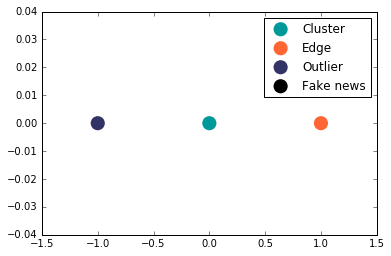

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots()
ax.scatter(0,0,s=200,c='#009999',edgecolors='none',label='Cluster')
ax.scatter(1,0,s=200,c='#FF6633',edgecolors='none',label='Edge')
ax.scatter(-1,0,s=200,c='#333366',edgecolors='none',label='Outlier')
ax.scatter([],[],s=200,c='#000000',edgecolors='none',label='Fake news')
ax.legend(scatterpoints=1)
plt.show()